<a href="https://colab.research.google.com/github/4LC4NT4R4/XMLD/blob/main/poo_xmld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import os
from datetime import datetime

!pip install ipympl
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Coleta de dados

Função importa dados baseados no detector vortex utilizado na linha de luz EMA

In [3]:
class DataImporter:
    def __init__(self, path):
        self.path = path
        self.measurements = []  # Lista para armazenar cada medida individualmente
        self._load_data()  # Chama o método para carregar dados

    def _load_data(self):
        """
        Carrega dados de um arquivo CSV contendo múltiplas medidas e armazena metadados de cada medida.
        """
        try:
            with open(self.path, 'r') as arquivo_csv:
                reader_csv = csv.reader(arquivo_csv)
                metadata = {}
                data = []  # Lista temporária para acumular dados da medida atual
                data_started = False  # Flag para indicar se os dados já começaram
                col = []  # Variável para armazenar o cabeçalho das colunas

                for line in reader_csv:
                    # Divide e ignora linhas vazias
                    line = line[0].split() if line else []

                    if not line:
                        continue  # Pula linhas vazias

                    # Início de uma nova medida: salva a medida anterior (se existir)
                    if line[0] == '#S' and data:
                        # Concatena os dados acumulados em um DataFrame
                        df = pd.DataFrame(data, columns=col)  # Cria o DataFrame com os dados acumulados
                        self.measurements.append({"metadata": metadata, "data": df})
                        metadata = {}  # Reinicializa metadados para a nova medida
                        data = []  # Reinicializa a lista de dados
                        data_started = False  # Reseta a flag
                        col = []  # Reseta o cabeçalho de colunas

                    # Coleta metadados das linhas de cabeçalho
                    if line[0] == '#F':
                        metadata['file_path'] = line[1]
                    elif line[0] == '#E':
                        metadata['energy'] = float(line[1])
                    elif line[0] == '#D':
                        metadata['date'] = " ".join(line[1:])
                    elif line[0] == '#C':
                        metadata['user'] = " ".join(line[2:])
                    elif line[0] == '#S':
                        metadata['scan_type'] = " ".join(line[1:])
                    elif line[0] == '#T':
                        metadata['time'] = " ".join(line[1:])
                    elif line[0] == '#N':
                        metadata['n_points'] = int(line[1])
                    elif line[0] == '#L':  # Linha de cabeçalho para as colunas dos dados
                        col = line[1:]  # Atualiza os nomes das colunas para a medida atual
                        data_started = True  # Os dados começaram a ser lidos
                    elif data_started:  # Apenas adiciona dados se já começamos a ler os dados
                        # Ajusta o número de colunas na linha de dados, adicionando valores vazios se necessário
                        adjusted_line = (line + [None] * (len(col) - len(line)))[:len(col)]
                        # Converte os valores para float (se possível) e adiciona à lista de dados
                        data.append([float(item) if item and item.replace('.', '', 1).isdigit() else item for item in adjusted_line])

                # Adiciona a última medida, se presente
                if data:
                    df = pd.DataFrame(data, columns=col)
                    self.measurements.append({"metadata": metadata, "data": df})

        except Exception as e:
            print(f"Erro ao carregar dados: {e}")

# # Exemplo de uso
# arq1='B1_MnK_08_A14062024_191717.csv'
# path='/content/drive/MyDrive/JupyterPrograms/XMLD/data_2024/'
# importer = DataImporter(path+arq1)
# print(len(importer.measurements))
# print(importer.measurements[0]['data'])
# print(importer.measurements[0]['metadata'])

# X=importer.measurements[0]['data']['Energy']
# Y=importer.measurements[0]['data']['roi41']


#Função principal

Armazena as funções básicas para normalizar os dados

In [4]:
class Spectrum:

    def __init__(self, x, y, pre=None, pos=None, E0=None, Ei=None, Ef=None, shift=None, n=1, m=1, flattering=True, name=None, legend=None, treshhold='derivative'):
        self.name = name
        self.legend = legend
        self.theshhold_set= treshhold #'derivative' or 'whiteline'

        self._x = np.array(x)
        self._y = np.array(y)
        self._Ei=Ei #Cut the x,y data bellow Ei
        self._Ef=Ef #Cut the x,y data above Ef
        self._shift=shift #Energy shift
        self.dy_dx = np.gradient(y, x) #Derivative of y with repect to x
        self._E0 = E0 #Energy theshhold
        self._n=n
        self._m=m
        self._flattering=flattering
        self._pre = pre if pre is not None else [-90, -40]
        self._pos = pos if pos is not None else [31, 142]

        #Given after normalization
        self.f = np.zeros_like
        self.p = np.zeros_like

        self.apply_shift()
        self.cut_data()
        self.set_E0()

        self.info = {
            'E0': self._E0,
            'Ei': self._Ei,
            'Ef': self._Ef,
            'shift': self._shift,
            'pre': self._pre,
            'pos': self._pos,
            'n': self._n,
            'm': self._m,
            'flattering': self._flattering
        }

        self.norm_y = self.norm(self._x, self._y, self._E0, pre_edge=self._pre, pos_edge=self._pos, n=self._n, m=self._m, flattering=self._flattering)

    def cut_data(self):
        # Cria uma máscara inicial válida para todos os elementos
        mask = np.ones(len(self._x), dtype=bool)

        # Ajusta a máscara com base nos limites definidos
        if self.Ei is not None:
            mask &= (self._x >= self.Ei)
        if self.Ef is not None:
            mask &= (self._x <= self.Ef)

        # Aplica a máscara nos arrays de forma consistente
        self._x = self._x[mask]
        self._y = self._y[mask]
        self.dy_dx = self.dy_dx[mask]

        # Verifica se os tamanhos ainda são consistentes após o corte
        if len(self._x) != len(self._y):
            raise ValueError(f"Tamanhos inconsistentes após corte: x={len(self._x)}, y={len(self._y)}")


    def apply_shift(self):
        if self.shift is not None:
            self._x += self.shift / 1000

    def set_E0(self):
        if self._E0 is None:
            if self.theshhold_set=='derivative':
                self._E0 = self._x[np.argmax(self.dy_dx)]
            elif self.theshhold_set=='whiteline':
                self._E0 = self._x[np.argmax(self._y)]

    # Normalização de energia em eV
    def norm(self, x, y, e0, pre_edge, pos_edge, n=1, m=1, flattering=True):

        if np.all(y == 0):  # Verificação de valores nulos em y
            print("Todos os valores de y são zero. Normalização será ajustada.")
            return np.zeros_like(y)

        X = np.array(x, dtype='float')
        Y = np.array(y, dtype='float')

        # Pré-borda (pre-edge)
        mask_pre = (X >= e0 + (pre_edge[0] / 1000)) & (X <= e0 + (pre_edge[1] / 1000))
        x_pre = X[mask_pre]
        y_pre = Y[mask_pre]

        # Ajuste polinomial para a pré-borda
        coefficients_pre = np.polyfit(x_pre, y_pre, n)
        p = np.poly1d(coefficients_pre)
        self.p = p

        # Pós-borda (post-edge)
        mask_pos = (X >= e0 + (pos_edge[0] / 1000)) & (X <= e0 + (pos_edge[1] / 1000))
        x_pos = X[mask_pos]
        y_pos = Y[mask_pos]

        # Ajuste polinomial para a pós-borda
        coefficients_pos = np.polyfit(x_pos, y_pos, m)
        f = np.poly1d(coefficients_pos)
        self.f=f

        # Cálculo do edge step
        edge_step = f(e0) - p(e0)

        # Normalização
        if flattering:
            Y = Y - p(X) * (1 - np.heaviside(X - e0, 1))
            Y = Y + (edge_step - f(X)) * np.heaviside(X - e0, 1)
            Y = Y / edge_step
        else:
            Y = Y - p(X)
            Y = Y / edge_step

        return Y

    @property
    def x(self):
        return self._x

    @x.setter
    def x(self, x):
        self._x = np.array(x)
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def y(self):
        return self._y

    @y.setter
    def y(self, y):
        self._y = np.array(y)
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def E0(self):
        return self._E0

    @E0.setter
    def E0(self, E0):
        self._E0 = E0
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def Ei(self):
        return self._Ei

    @Ei.setter
    def Ei(self, Ei):
        self._Ei = Ei

    @property
    def Ef(self):
        return self._Ef

    @Ef.setter
    def Ef(self, Ef):
        self._Ef = Ef

    @property
    def shift(self):
        return self._shift

    @shift.setter
    def shift(self, shift):
        self._shift = shift

    @property
    def pre(self):
        return self._pre

    @pre.setter
    def pre(self, pre):
        self._pre = pre
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def pos(self):
        return self._pos

    @pos.setter
    def pos(self, pos):
        self._pos = pos
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def n(self):
        return self._n

    @n.setter
    def n(self, n):
        self._n = n
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)


    @property
    def m(self):
        return self._m

    @m.setter
    def m(self, m):
        self._m = m
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    @property
    def flattering(self):
        return self._flattering

    @flattering.setter
    def flattering(self, flattering):
        self._flattering = flattering
        self.norm_y = self.norm(self._x, self._y, self.E0, pre_edge=self.pre, pos_edge=self.pos, n=self.n, m=self.m, flattering=self.flattering)

    def update_params(self, **kwargs):
        """
        Atualiza os parâmetros da classe e recalcula o espectro normalizado.
        """
        for key, value in kwargs.items():
            if hasattr(self, f"_{key}"):
                setattr(self, f"_{key}", value)
        self.norm_y = self.norm(self._x, self._y, self._E0, pre_edge=self._pre, pos_edge=self._pos, n=self._n, m=self._m, flattering=self._flattering)


    def plot_derivative(self):
        fig, ax =plt.subplots()
        ax.title.set_text('Raw\'s data derivative')
        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('dY/dX')
        ax.plot(self.x, self.dy_dx)
        ax.scatter(self.x[np.argmax(self.dy_dx)], np.max(self.dy_dx), marker='x', color='r')
        plt.grid()
        plt.show()


    def plot_normalized(self):
        fig, ax =plt.subplots()
        ax.plot(self.x, self.norm_y)
        ax.title.set_text('Normalized data')
        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('Intensity (arb. units)')
        plt.grid()
        plt.show()

    def plot_parameters(self):
        fig, ax =plt.subplots()
        ax.plot(self.x, self.y)
        ax.plot(self.x,self.f(self.x))
        ax.plot(self.x,self.p(self.x))
        ax.axvline(x=self.E0+self.pre[0]/1000, color='r', linestyle='--')
        ax.axvline(x=self.E0+self.pre[1]/1000, color='r', linestyle='--')
        ax.axvline(x=self.E0+self.pos[0]/1000, color='g', linestyle='--')
        ax.axvline(x=self.E0+self.pos[1]/1000, color='g', linestyle='--')

        ax.title.set_text('Raw\'s data')
        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('Y')
        plt.grid()
        plt.show()




# a=Spectrum(X,Y, pre=[-250,-80], pos=[80, 200])
# a.plot_derivative()
# a.plot_parameters()
# a.plot_normalized()

#Função específica

Trata 4 canais do detector Vortex simultaneamente

In [49]:
class Vortex:
    def __init__(self, path=None, measure=0, roi=2, s1=None, s2=None, s3=None, s4=None,  **spectrum_params):
        """
        Inicializa a classe Vortex. Pode-se fornecer um caminho para um arquivo CSV (path)
        ou quatro espectros (s1, s2, s3, s4) diretamente.
        """
        self.path = path
        self._roi = roi
        self._spectrum_params = spectrum_params # Parametros que serão passados para os espectros
        self._measure = measure # Escolha da medida
        self.number_of_measurements = None # Número de medidas
        self.data = None # Dados brutos

        # Atributos de metadados
        self.name = os.path.basename(path) if path else None
        self.date = '_'.join(self.path.split("_")[-2:]) if path else None
        self.legend = '_'.join(self.path.split("_")[1:4]) if path else None

        # Inicializar espectros
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.s4 = s4


        # Carregar dados dos espectros
        self.load_data()

        # Lista de espectros
        self.spectra = [self.s1, self.s2, self.s3, self.s4]

        # Espectro somado
        if all(self.spectra):
            print(self.spectrum_params)
            self.s = Spectrum(x=self.s1.x, y = self.s1.y + self.s2.y + self.s3.y + self.s4.y, **self.spectrum_params)
        else:
            self.s = None

    def load_data(self):
        """
        Carrega dados de um arquivo CSV.
        """
        if self.path:
        # Importar dados
            arxiv = DataImporter(self.path)
            self.number_of_measurements=len(arxiv.measurements)
            self.data = arxiv.measurements[self._measure]['data']

            if self.data is not None:
                try:
                    self.s1 = Spectrum(self.data['Energy'], self.data[f'roi{self._roi}1'] / self.data['I0'], **self.spectrum_params)
                except:
                    print(f'Erro no roi{self._roi}1')
                    self.s1 = Spectrum(self.data['Energy'], np.zeros(len(self.data['Energy'])), **self.spectrum_params)
                try:
                    self.s2 = Spectrum(self.data['Energy'], self.data[f'roi{self._roi}2'] / self.data['I0'], **self.spectrum_params)
                except:
                    print(f'Erro no roi{self._roi}2')
                    self.s2 = Spectrum(self.data['Energy'], np.zeros(len(self.data['Energy'])), **self.spectrum_params)

                try:
                    self.s3 = Spectrum(self.data['Energy'], self.data[f'roi{self._roi}3'] / self.data['I0'], **self.spectrum_params)
                except:
                    print(f'Erro no roi{self._roi}3')
                    self.s3 = Spectrum(self.data['Energy'], np.zeros(len(self.data['Energy'])), **self.spectrum_params)

                try:
                    self.s4 = Spectrum(self.data['Energy'], self.data[f'roi{self._roi}4'] / self.data['I0'], **self.spectrum_params)
                except:
                    print(f'Erro no roi{self._roi}4')
                    self.s4 = Spectrum(self.data['Energy'], np.zeros(len(self.data['Energy'])), **self.spectrum_params)





    @property
    def roi(self):
        return self._roi

    @roi.setter
    def roi(self, roi):
        self._roi = roi
        self.load_data()

    @property
    def measure(self):
        return self._measure


    @measure.setter
    def measure(self, measure):
        self._measure = measure
        self.load_data()

    @property
    def spectrum_params(self):
        return self._spectrum_params

    @spectrum_params.setter
    def spectrum_params(self, spectrum_params):
        self._spectrum_params = spectrum_params
        self.s1.update_params(**spectrum_params)
        self.s2.update_params(**spectrum_params)
        self.s3.update_params(**spectrum_params)
        self.s4.update_params(**spectrum_params)

        self.spectra = [self.s1, self.s2, self.s3, self.s4]

        if all(self.spectra):
            self.s = Spectrum(self.s1.x, self.s1.y + self.s2.y + self.s3.y + self.s4.y, **self.spectrum_params)
        else:
            self.s = None




    def plot_derivative(self, **kwargs):
        """
        Plota as derivadas dos espectros s1, s2, s3 e s4.
        """
        figsize = kwargs.get('figsize', (6, 6))  # Tamanho padrão da figura
        xlimit = kwargs.get('xlimit', None)      # Limite padrão para o eixo x (nenhum)
        ylimit = kwargs.get('ylimit', None)      # Limite padrão para o eixo y (nenhum)
        shift=kwargs.get('shift', 0)
        xline=kwargs.get('xline', None)
        xline_=kwargs.get('xline_', None)



        fig, axs = plt.subplots(figsize=figsize)
        for i, spectrum in enumerate(self.spectra, start=1):
            if spectrum:
                axs.plot(spectrum._x, spectrum.dy_dx, marker=str(i), label=f'ROI{self._roi}{i}')
                axs.scatter(spectrum._x[np.argmax(spectrum.dy_dx)], np.max(spectrum.dy_dx), color='black')

        axs.set_xlabel("Energy (eV)")
        axs.set_ylabel("dY/dX")
        axs.legend()
        axs.title.set_text('Raw\'s data derivative')
        plt.grid()

        #Extras
        if xlimit:
            axs.set_xlim(xlimit)
        if ylimit:
            axs.set_ylim(ylimit)
        if xline_:
            axs.axvline(x=xline_, color='black', linestyle='--')
        if xline:
            axs.axvline(x=xline, color='r', linestyle='--')

        plt.show()



    def plot_raw_data(self, **kwargs):
        """
        Plota os dados brutos (não normalizados) dos espectros s1, s2, s3 e s4.
        """
        figsize = kwargs.get('figsize', (7, 7))  # Tamanho padrão da figura
        xlimit = kwargs.get('xlimit', None)      # Limite padrão para o eixo x (nenhum)
        ylimit = kwargs.get('ylimit', None)      # Limite padrão para o eixo y (nenhum)
        shift=kwargs.get('shift', 0)
        xline=kwargs.get('xline', None)
        xline_=kwargs.get('xline_', None)


        fig, ax = plt.subplots(2, 2, sharex='col', figsize= figsize)
        titles = ['Spectrum 1', 'Spectrum 2', 'Spectrum 3', 'Spectrum 4']

        for i, spectrum in enumerate(self.spectra):
            if spectrum:
                ax[i // 2, i % 2].plot(spectrum.x, spectrum.y, label=f'ROI{self._roi}{i+1}')
                ax[i // 2, i % 2].axvline(x=spectrum.E0+spectrum.pre[0]/1000, color='r', linestyle='--')
                ax[i // 2, i % 2].axvline(x=spectrum.E0+spectrum.pre[1]/1000, color='r', linestyle='--')
                ax[i // 2, i % 2].axvline(x=spectrum.E0+spectrum.pos[0]/1000, color='g', linestyle='--')
                ax[i // 2, i % 2].axvline(x=spectrum.E0+spectrum.pos[1]/1000, color='g', linestyle='--')
                ax[i // 2, i % 2].plot(spectrum.x, spectrum.f(spectrum.x), label='f')
                ax[i // 2, i % 2].plot(spectrum.x, spectrum.p(spectrum.x), label='p')
                ax[i // 2, i % 2].set_title(titles[i])
                ax[i // 2, i % 2].legend()
                ax[i // 2, i % 2].grid()

        plt.suptitle('Raw\'s data')

        plt.tight_layout()

        #Extras
        if xlimit:
            axs.set_xlim(xlimit)
        if ylimit:
            axs.set_ylim(ylimit)
        if xline_:
            axs.axvline(x=xline_, color='black', linestyle='--')
        if xline:
            axs.axvline(x=xline, color='r', linestyle='--')

        plt.show()

    def plot_normalized(self, **kwargs):
        """
        Plota os dados normalizados dos espectros s1, s2, s3 e s4.
        """
        figsize = kwargs.get('figsize', (7, 7))  # Tamanho padrão da figura
        xlimit = kwargs.get('xlimit', None)      # Limite padrão para o eixo x (nenhum)
        ylimit = kwargs.get('ylimit', None)      # Limite padrão para o eixo y (nenhum)
        shift=kwargs.get('shift', 0)
        xline=kwargs.get('xline', None)
        xline_=kwargs.get('xline_', None)


        fig, ax = plt.subplots(2, 2, sharex='col')
        titles = ['Spectrum 1', 'Spectrum 2', 'Spectrum 3', 'Spectrum 4']

        for i, spectrum in enumerate(self.spectra):
            if spectrum:
                ax[i // 2, i % 2].plot(spectrum.x, spectrum.norm_y, label=f'ROI{self._roi}{i+1}')
                ax[i // 2, i % 2].set_title(titles[i])
                ax[i // 2, i % 2].legend()
                ax[i // 2, i % 2].grid()

        plt.tight_layout()
        plt.suptitle('Normalized data')

        #Extras
        if xlimit:
            axs.set_xlim(xlimit)
        if ylimit:
            axs.set_ylim(ylimit)
        if xline_:
            axs.axvline(x=xline_, color='black', linestyle='--')
        if xline:
            axs.axvline(x=xline, color='r', linestyle='--')

        plt.show()

    def info(self):
       print( {'roi':self._roi,
        'Nº of measurements':self.number_of_measurements,
        'Measure': self._measure} | self.s1.info)




OPERAÇÕES DE SOMA E SUBTRAÇÃO DE DOIS OBJETOS VORTEX

In [8]:
# arq1='B1_MnK_08_A14062024_191717.csv'
# arq2='s0098_M6_frame_RT_Co_3_A15062024_080233.csv'
# arq3='s0117_M6_noframe_RT_Co_2_A15062024_131851.csv'
# arq4='s0118_M6_noframe_RT_Co_3_A15062024_133009.csv'

# path='/content/drive/MyDrive/JupyterPrograms/XMLD/data_2024/'

# c=Vortex(path+arq1, roi=1, measure=0, pre=[-250, -80], pos=[80, 200])


# c.plot_derivative()
# c.plot_raw_data()
# c.plot_normalized()

# print(c.info)
# print(c.name)
# print(c.legend)
# print(c.date)

In [43]:
def SUM (vtx1, vtx2):

    s1_ = Spectrum(x=vtx1.s1.x, y= np.interp(vtx1.s1.x, vtx2.s1.x, vtx2.s1.y) + vtx1.s1.y)
    s2_ = Spectrum(x=vtx1.s2.x, y= np.interp(vtx1.s2.x, vtx2.s2.x, vtx2.s2.y) + vtx1.s2.y)
    s3_ = Spectrum(x=vtx1.s3.x, y= np.interp(vtx1.s3.x, vtx2.s3.x, vtx2.s3.y) + vtx1.s3.y)
    s4_ = Spectrum(x=vtx1.s4.x, y= np.interp(vtx1.s4.x, vtx2.s4.x, vtx2.s4.y) + vtx1.s4.y)

    return Vortex(s1=s1_, s2=s2_, s3=s3_, s4=s4_)


def nSUM(vtx_list):
    sum = vtx_list[0]
    for i in range(1, len(vtx_list)):
        sum = SUM(sum, vtx_list[i])
    return sum

def SUB(vtx1, vtx2):

    s1_ = Spectrum(x=vtx1.s1.x, y= np.interp(vtx1.s1.x, vtx2.s1.x, vtx2.s1.y) - vtx1.s1.y)
    s2_ = Spectrum(x=vtx1.s2.x, y= np.interp(vtx1.s2.x, vtx2.s2.x, vtx2.s2.y) - vtx1.s2.y)
    s3_ = Spectrum(x=vtx1.s3.x, y= np.interp(vtx1.s3.x, vtx2.s3.x, vtx2.s3.y) - vtx1.s3.y)
    s4_ = Spectrum(x=vtx1.s4.x, y= np.interp(vtx1.s4.x, vtx2.s4.x, vtx2.s4.y) - vtx1.s4.y)

    return Vortex(s1=s1_, s2=s2_, s3=s3_, s4=s4_)

def nSUB(vtx_list):
    sub = vtx_list[0]
    for i in range(1, len(vtx_list)):
        sub = SUB(sub, vtx_list[i])
    return sub

Todos os valores de y são zero. Normalização será ajustada.
{'pre': [-250, -80], 'pos': [80, 200]}
Todos os valores de y são zero. Normalização será ajustada.
{'pre': [-250, -80], 'pos': [80, 200]}
Todos os valores de y são zero. Normalização será ajustada.
{}
Todos os valores de y são zero. Normalização será ajustada.
{}


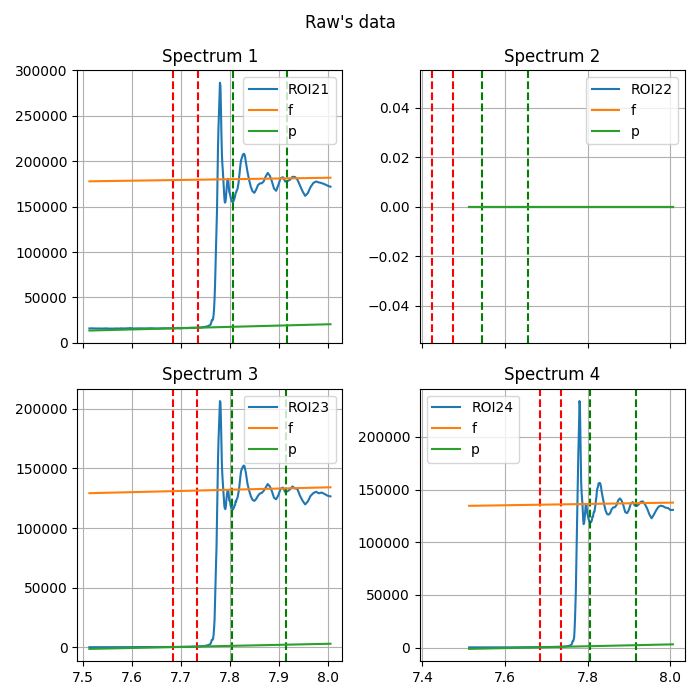

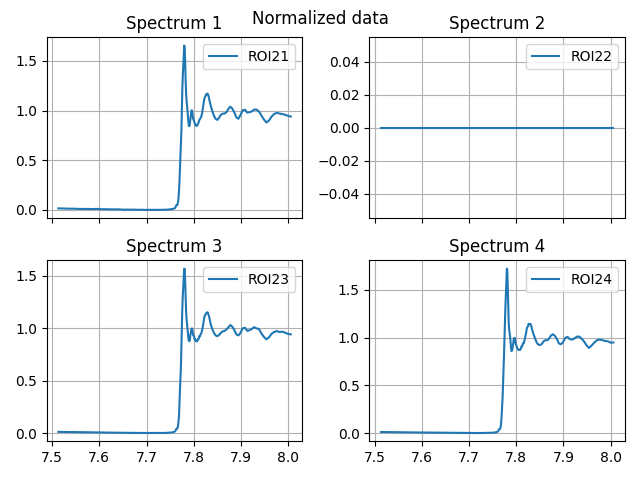

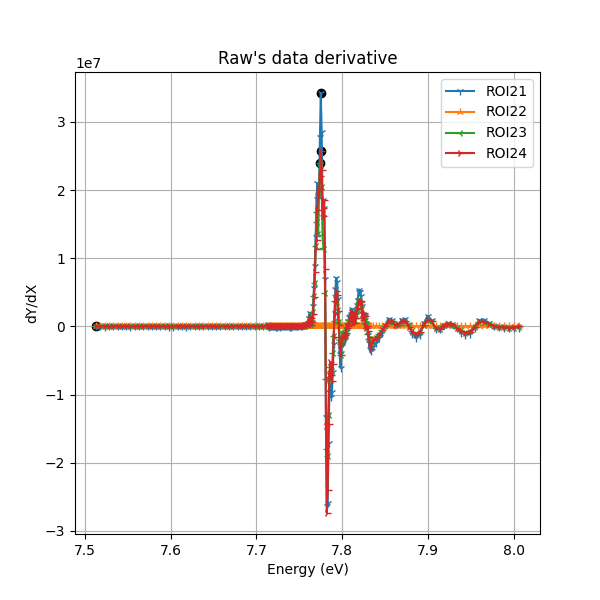

In [50]:
arq1='B1_MnK_08_A14062024_191717.csv'
arq2='s0098_M6_frame_RT_Co_3_A15062024_080233.csv'
arq3='s0117_M6_noframe_RT_Co_2_A15062024_131851.csv'
arq4='s0118_M6_noframe_RT_Co_3_A15062024_133009.csv'

path='/content/drive/MyDrive/JupyterPrograms/XMLD/data_2024/'

c=Vortex(path+arq3, roi=2, measure=0, pre=[-250, -80], pos=[80, 200])
d=Vortex(path+arq4, roi=2, measure=0, pre=[-250, -80], pos=[80, 200])

# c.plot_raw_data()
# d.plot_raw_data()
e=SUM(c,d)
f=SUB(c,d)
e.plot_raw_data()
e.plot_normalized()
e.plot_derivative()
# f.plot_raw_data()

In [51]:
import numpy as np
from scipy.integrate import simps

# Dados experimentais
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 1, 4, 9, 16, 25])

# Defina o intervalo
a, b = 1, 4  # Limites desejados
mask = (x >= a) & (x <= b)  # Seleciona pontos no intervalo

# Integração no intervalo definido
integral_trapz = np.trapz(y[mask], x[mask])
integral_simps = simps(y[mask], x[mask])

print(f"Integral (trapézio) no intervalo [{a}, {b}]: {integral_trapz}")
print(f"Integral (Simpson) no intervalo [{a}, {b}]: {integral_simps}")


Integral (trapézio) no intervalo [1, 4]: 21.5
Integral (Simpson) no intervalo [1, 4]: 21.0


<ipython-input-51-1575988eeeb3>:14: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral_simps = simps(y[mask], x[mask])


# Data visualization

In [77]:
class xmld4:
    def __init__(self, arq1, arq2, arq3, arq4, title=None, **vortex_params):

        self.title = title
        self.vortex_params = vortex_params

        # Salve os nomes dos arquivos para uso posterior
        self.arq1 = arq1
        self.arq2 = arq2
        self.arq3 = arq3
        self.arq4 = arq4

        # Dados Brutos
        self.n1 = Vortex(arq1, **self.vortex_params)
        self.n2 = Vortex(arq2, **self.vortex_params)
        self.n3 = Vortex(arq3, **self.vortex_params)
        self.n4 = Vortex(arq4, **self.vortex_params)

        self.interpolate()






    def interpolate(self):
        # Interpolação entre os dados
        for i in range(1, 5):
            source = getattr(self, f'n{i}')
            target = self.n1
            for attr in ['s1', 's2', 's3', 's4']:
                spec_target = getattr(target, attr)
                spec_source = getattr(source, attr)
                spec_source.update_params(
                    x=spec_target.x,
                    y=np.interp(spec_target.x, spec_source.x, spec_source.y))


    def calculate_integrals(self, interval=None):
        int_interval=interval
        # Verifica se int_interval está definido
        if int_interval is None:
            # Considera o intervalo completo
            mask = slice(None)  # Seleciona todos os elementos
        else:
            # Define a máscara com base no intervalo fornecido
            mask = (self.n1.s.x >= int_interval[0]) & (self.n1.s.x <= int_interval[1])

        # Calcula as integrais para as diferenças norm_y
        s_21_int = np.trapz(self.n2.s.norm_y[mask] - self.n1.s.norm_y[mask], self.n1.s.x[mask])
        s_43_int = np.trapz(self.n4.s.norm_y[mask] - self.n3.s.norm_y[mask], self.n3.s.x[mask])

        # Calcula as integrais individuais (s1, s2, s3, s4) para cada par
        s1_21_int = np.trapz(self.n2.s1.norm_y[mask] - self.n1.s1.norm_y[mask], self.n1.s1.x[mask])
        s2_21_int = np.trapz(self.n2.s2.norm_y[mask] - self.n1.s2.norm_y[mask], self.n1.s2.x[mask])
        s3_21_int = np.trapz(self.n2.s3.norm_y[mask] - self.n1.s3.norm_y[mask], self.n1.s3.x[mask])
        s4_21_int = np.trapz(self.n2.s4.norm_y[mask] - self.n1.s4.norm_y[mask], self.n1.s4.x[mask])

        s1_43_int = np.trapz(self.n4.s1.norm_y[mask] - self.n3.s1.norm_y[mask], self.n3.s1.x[mask])
        s2_43_int = np.trapz(self.n4.s2.norm_y[mask] - self.n3.s2.norm_y[mask], self.n3.s2.x[mask])
        s3_43_int = np.trapz(self.n4.s3.norm_y[mask] - self.n3.s3.norm_y[mask], self.n3.s3.x[mask])
        s4_43_int = np.trapz(self.n4.s4.norm_y[mask] - self.n3.s4.norm_y[mask], self.n3.s4.x[mask])

        # Retorna os resultados das integrais
        return {
            "s_21_int": s_21_int,
            "s_43_int": s_43_int,
            "s1_21_int": s1_21_int,
            "s2_21_int": s2_21_int,
            "s3_21_int": s3_21_int,
            "s4_21_int": s4_21_int,
            "s1_43_int": s1_43_int,
            "s2_43_int": s2_43_int,
            "s3_43_int": s3_43_int,
            "s4_43_int": s4_43_int,
        }


    # Propriedades e Setters para acessar o atributo `measure` de cada instância
    @property
    def n1_measure(self):
        return self.n1.measure

    @n1_measure.setter
    def n1_measure(self, measure):
        self.n1 = Vortex(self.arq1, **self.vortex_params, measure=measure)
        self.interpolate()

    @property
    def n2_measure(self):
        return self.n2.measure

    @n2_measure.setter
    def n2_measure(self, measure):
        self.n2 = Vortex(self.arq2, **self.vortex_params, measure=measure)
        self.interpolate()

    @property
    def n3_measure(self):
        return self.n3.measure

    @n3_measure.setter
    def n3_measure(self, measure):
        self.n3 = Vortex(self.arq3, **self.vortex_params, measure=measure)
        self.interpolate()

    @property
    def n4_measure(self):
        return self.n4.measure

    @n4_measure.setter
    def n4_measure(self, measure):
        self.n4 = Vortex(self.arq4, **self.vortex_params, measure=measure)
        self.interpolate()


    def plot_derivative(self, **kwargs):
        """
        Plota as derivadas dos espectros s1, s2, s3 e s4.
        """
        figsize = kwargs.get('figsize', (8, 8))  # Tamanho padrão da figura
        xlimit = kwargs.get('xlimit', None)      # Limite padrão para o eixo x (nenhum)
        ylimit = kwargs.get('ylimit', None)      # Limite padrão para o eixo y (nenhum)
        xline=kwargs.get('xline', None)
        xline_=kwargs.get('xline_', None)

        fig, axs = plt.subplots(2, 2, sharex=True)
        fig.suptitle('Raw\'s data derivative')

        axs[0][0].plot(self.n1.s1.x, self.n1.s1.dy_dx)
        axs[0][0].plot(self.n2.s1.x, self.n2.s1.dy_dx)
        axs[0][0].plot(self.n3.s1.x, self.n3.s1.dy_dx)
        axs[0][0].plot(self.n4.s1.x, self.n4.s1.dy_dx)

        axs[0][1].plot(self.n1.s2.x, self.n1.s2.dy_dx)
        axs[0][1].plot(self.n2.s2.x, self.n2.s2.dy_dx)
        axs[0][1].plot(self.n3.s2.x, self.n3.s2.dy_dx)
        axs[0][1].plot(self.n4.s2.x, self.n4.s2.dy_dx)

        axs[1][0].plot(self.n1.s3.x, self.n1.s3.dy_dx)
        axs[1][0].plot(self.n2.s3.x, self.n2.s3.dy_dx)
        axs[1][0].plot(self.n3.s3.x, self.n3.s3.dy_dx)
        axs[1][0].plot(self.n4.s3.x, self.n4.s3.dy_dx)

        axs[1][1].plot(self.n1.s4.x, self.n1.s4.dy_dx)
        axs[1][1].plot(self.n2.s4.x, self.n2.s4.dy_dx)
        axs[1][1].plot(self.n3.s4.x, self.n3.s4.dy_dx)
        axs[1][1].plot(self.n4.s4.x, self.n4.s4.dy_dx)

        for ax in axs.flat:
            ax.set(xlabel='Energy (eV)', ylabel='dY/dX')
            ax.grid(True)

        #Extras
        if xlimit:
            axs.set_xlim(xlimit)
        if ylimit:
            axs.set_ylim(ylimit)
        if xline_:
            axs.axvline(x=xline_, color='black', linestyle='--')
        if xline:
            axs.axvline(x=xline, color='r', linestyle='--')


        plt.tight_layout()
        plt.show()



    def plot_rois(self, **kwargs):

        figsize = kwargs.get('figsize', (10, 10))  # Tamanho padrão da figura
        xlimit = kwargs.get('xlimit', None)      # Limite padrão para o eixo x (nenhum)
        ylimit = kwargs.get('ylimit', None)      # Limite padrão para o eixo y (nenhum)
        xline=kwargs.get('xline', None)
        xline_=kwargs.get('xline_', None)

        # Cria a figura e os subplots
        fig, axs = plt.subplots(4, 2, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 3, 4, 3]}, sharex=True)
        fig.suptitle(self.title or 'Title')

        l = 0
        m = 0

        for i, ax in enumerate(axs.flatten()):

            if i == 0 or i == 1 or i == 4 or i == 5:
                if i == 0 or i == 4:
                    ax.set_ylabel('XAS(Normd)')
                ax.set_title(f'roi2{l+1}')

                # Definir os dados de espectro para o subplot
                x1, y1 = self.n1.spectra[l].x, self.n1.spectra[l].norm_y
                x2, y2 = self.n2.spectra[l].x, self.n2.spectra[l].norm_y
                x3, y3 = self.n3.spectra[l].x, self.n3.spectra[l].norm_y
                x4, y4 = self.n4.spectra[l].x, self.n4.spectra[l].norm_y

                # Plotar os dados
                ax.scatter(x1, y1, marker='1', label=f'n1: {self.n1.legend}')
                ax.scatter(x2, y2, marker='2', label=f'n2: {self.n2.legend}')
                ax.scatter(x3, y3, marker='3', label=f'n3: {self.n3.legend}')
                ax.scatter(x4, y4, marker='4', label=f'n4: {self.n4.legend}')

                ax.grid()
                ax.legend()
                l += 1

            elif i == 2 or i == 3 or i == 6 or i == 7:

                # Diferença entre os espectros
                diff1 = self.n2.spectra[m].norm_y - self.n1.spectra[m].norm_y
                diff2 = self.n4.spectra[m].norm_y - self.n3.spectra[m].norm_y

                ax.plot(self.n1.spectra[m].x, diff1, label='n2 - n1')
                ax.plot(self.n3.spectra[m].x, diff2, label='n4 - n3')

                if i == 6 or i == 7 or i == 2:
                    ax.set_xlabel('Energy (eV)')
                if i == 2 or i == 6:
                    ax.set_ylabel('XMLD')

                ax.grid()
                ax.legend()
                m += 1
        plt.tight_layout()

        #Extras
        if xlimit:
            axs.set_xlim(xlimit)
        if ylimit:
            axs.set_ylim(ylimit)
        if xline_:
            axs.axvline(x=xline_, color='black', linestyle='--')
        if xline:
            axs.axvline(x=xline, color='r', linestyle='--')

        plt.show()


    def plot(self, **kwargs):
        figsize = kwargs.get('figsize', (6, 8))  # Tamanho padrão da figura
        xlimit = kwargs.get('xlimit', None)      # Limite padrão para o eixo x (nenhum)
        ylimit = kwargs.get('ylimit', None)      # Limite padrão para o eixo y (nenhum)
        shift=kwargs.get('shift', 0)
        xline=kwargs.get('xline', None)
        xline_=kwargs.get('xline_', None)

        # Crie a figura e os eixos com ajuste de espaçamento vertical e proporções de altura
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=figsize)

        # Plote o primeiro gráfico
        ax1.scatter(self.n1.s.x+shift, self.n1.s.norm_y, marker='1', label=f'n1: {self.n1.legend}')
        ax1.scatter(self.n2.s.x+shift, self.n2.s.norm_y, marker='2', label=f'n2: {self.n2.legend}')
        ax1.scatter(self.n3.s.x+shift, self.n3.s.norm_y, marker='3', label=f'n3: {self.n3.legend}')
        ax1.scatter(self.n4.s.x+shift, self.n4.s.norm_y, marker='4', label=f'n4: {self.n4.legend}')
        ax1.grid()
        ax1.legend()
        ax1.set_ylabel('XAS (Normalizado)')

        # Plote o segundo gráfico no mesmo eixo
        ax2.plot(self.n1.s.x+shift, self.n2.s.norm_y - self.n1.s.norm_y, label='n2-n1')
        ax2.plot(self.n3.s.x+shift, self.n4.s.norm_y - self.n3.s.norm_y, label='n4-n3')
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel('Energia (eV)')
        ax2.set_ylabel('XMLD')

        if xline_:
            ax1.axvline(x=xline_, color='black', linestyle='--')
            ax2.axvline(x=xline_, color='black', linestyle='--')

        if xline:
            ax1.axvline(x=xline, color='r', linestyle='--')
            ax2.axvline(x=xline, color='r', linestyle='--')

        # Aplique os limites do eixo x, se fornecidos
        if xlimit:
            ax2.set_xlim(xlimit)

        # Aplique os limites do eixo y, se fornecidos
        if ylimit:
            ax2.set_ylim(ylimit)

        # Ajuste o layout para garantir que os gráficos não se sobreponham
        plt.tight_layout()

        # Exiba o gráfico
        plt.show()


    def plot_parameters(self, **kwargs):
        """
        Plota 4 gráficos, dois em cima e dois em baixo.
        Cada gráfico plota espectros equivalentes (s1, s2, s3, s4) de cada classe Vortex.
        """

        print(self.n1.info())
        print(self.n2.info())
        print(self.n3.info())
        print(self.n4.info())


        fig, axs = plt.subplots(2, 2, sharex=True, **kwargs)
        fig.suptitle('Raw data')

        # Nomes dos espectros e títulos dos subplots
        spectra = ['s1', 's2', 's3', 's4']
        titles = ['Spectrum s1', 'Spectrum s2', 'Spectrum s3', 'Spectrum s4']

        # Itera sobre os subplots e os espectros
        for idx, (ax, spectrum, title) in enumerate(zip(axs.flat, spectra, titles)):
            for n in [self.n1, self.n2, self.n3, self.n4]:
                # Obter o espectro atual (s1, s2, etc.) para o objeto Vortex (n)
                spec = getattr(n, spectrum)
                ax.plot(spec.x, spec.y, label=f'{n.legend}')
                ax.plot(spec.x, spec.f(spec.x))
                ax.plot(spec.x, spec.p(spec.x))
                ax.grid(True)

            # Adiciona as linhas verticais baseadas nos valores de `pre` e `pos` do espectro `s1` de `n1`
            base_spec = getattr(self.n1, spectrum)
            ax.axvline(x=base_spec.E0 + base_spec.pre[0] / 1000, color='r', linestyle='--')
            ax.axvline(x=base_spec.E0 + base_spec.pre[1] / 1000, color='r', linestyle='--')
            ax.axvline(x=base_spec.E0 + base_spec.pos[0] / 1000, color='g', linestyle='--')
            ax.axvline(x=base_spec.E0 + base_spec.pos[1] / 1000, color='g', linestyle='--')

            ax.set_title(title)
            ax.legend()

        plt.tight_layout()
        plt.show()









{'pre': [-45, -30], 'pos': [31, 142], 'Ei': 7.73}
{'pre': [-45, -30], 'pos': [31, 142], 'Ei': 7.73}
{'pre': [-45, -30], 'pos': [31, 142], 'Ei': 7.73}
{'pre': [-45, -30], 'pos': [31, 142], 'Ei': 7.73}
s_21_int: -5.47780371344038e-05
s_43_int: 5.902788367135427e-05
s1_21_int: -6.751749280306967e-05
s2_21_int: -5.2192550534683086e-05
s3_21_int: 2.0166932551619205e-05
s4_21_int: -0.00012222308640207077
s1_43_int: 9.029186037540289e-05
s2_43_int: 0.00011406206788442233
s3_43_int: 3.501172403533122e-05
s4_43_int: -7.246043320498186e-06


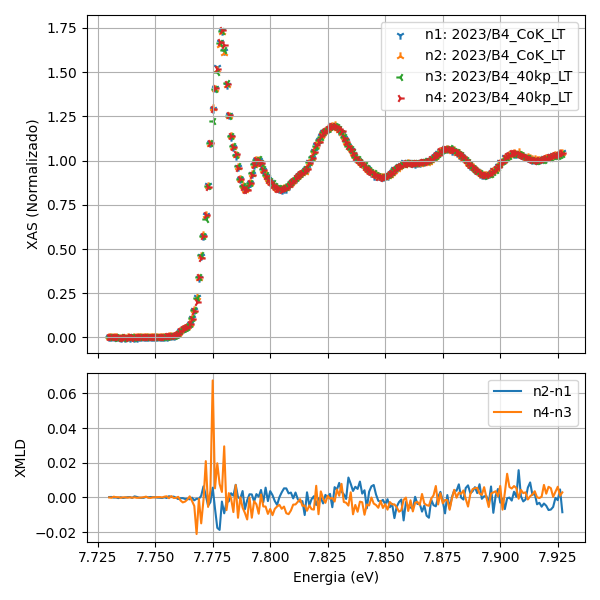

In [80]:

# Exemplo de uso
arq1='B4_CoK_LT_00_A03062023_032912.csv'
arq2='B4_CoK_LT_01_A03062023_035504.csv'
arq3='B4_40kp_LT_1_A03062023_135606.csv'
arq4='B4_40kp_LT_2_A03062023_140825.csv'

path = '/content/drive/MyDrive/JupyterPrograms/XMLD/data_2023/'

# # Instanciando e plotando
a = xmld4(path + arq1, path + arq2, path + arq3, path + arq4, pre=[-45,-30], pos=[31,142], Ei=7.73)


# a.plot_derivative()
# a.plot_rois()
# a.plot_parameters(figsize=(10, 10))
dic = a.calculate_integrals([7.760, 7.790])

for c in dic.keys():
    print(f"{c}: {dic[c]}")
a.plot(figsize=(6, 6))

In [ ]:
def plot_multiple_xmld4(xmld4_list, vertical_shift=0.1):
  """
  Plota vários objetos xmld4 em um único gráfico com deslocamento vertical.

  Args:
    xmld4_list: Uma lista de objetos xmld4 a serem plotados.
    vertical_shift: O valor do deslocamento vertical entre os plots.
  """

  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

  for i, xmld4_obj in enumerate(xmld4_list):
    # Deslocamento vertical para cada plot
    y_shift = i * vertical_shift

    # Plota XAS normalizado no primeiro eixo
    ax1.scatter(xmld4_obj.n1.s.x, xmld4_obj.n1.s.norm_y + y_shift, marker='1', label=f'n1: {xmld4_obj.n1.legend}:{xmld4_obj.n1.date}')
    ax1.scatter(xmld4_obj.n2.s.x, xmld4_obj.n2.s.norm_y + y_shift, marker='2', label=f'n2: {xmld4_obj.n2.legend}:{xmld4_obj.n2.date}')
    ax1.scatter(xmld4_obj.n3.s.x, xmld4_obj.n3.s.norm_y + y_shift, marker='3', label=f'n3: {xmld4_obj.n3.legend}:{xmld4_obj.n3.date}')
    ax1.scatter(xmld4_obj.n4.s.x, xmld4_obj.n4.s.norm_y + y_shift, marker='4', label=f'n4: {xmld4_obj.n4.legend}:{xmld4_obj.n4.date}')


    # Plota XMLD no segundo eixo
    ax2.plot(xmld4_obj.n1.s.x, (xmld4_obj.n2.s.norm_y - xmld4_obj.n1.s.norm_y) + y_shift, label=f'n2-n1: {xmld4_obj.n2.legend}')
    ax2.plot(xmld4_obj.n3.s.x, (xmld4_obj.n4.s.norm_y - xmld4_obj.n3.s.norm_y) + y_shift, label=f'n4-n3: {xmld4_obj.n4.legend}')

  ax1.grid()
  ax1.legend()
  ax1.set_ylabel('XAS (Normalizado)')

  ax2.legend()
  ax2.grid()
  ax2.set_xlabel('Energia (eV)')
  ax2.set_ylabel('XMLD')

  plt.tight_layout()
  plt.show()



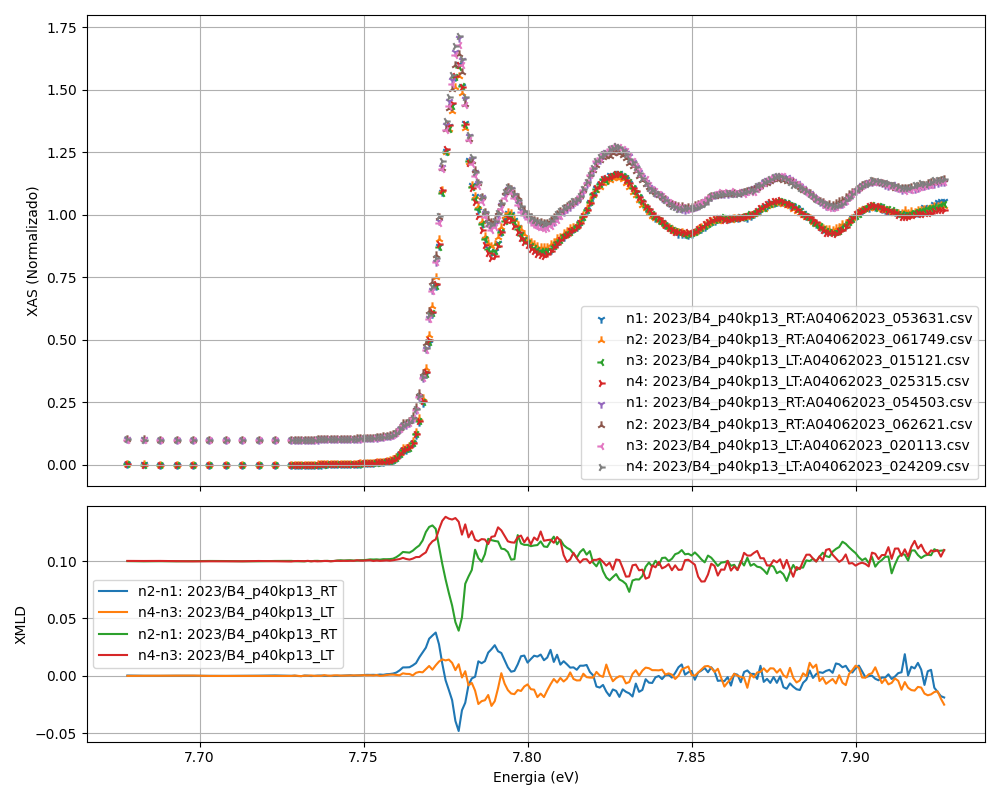

In [ ]:
# Exemplo de uso

path = '/content/drive/MyDrive/JupyterPrograms/XMLD/data_2023/'

arq1 = 'B4_p40kp13_RT_1_A04062023_053631.csv'
arq2 = 'B4_p40kp13_RT_3_A04062023_061749.csv'
arq3 = 'B4_p40kp13_LT_1_A04062023_015121.csv'
arq4 = 'B4_p40kp13_LT_3_A04062023_025315.csv'

a = xmld4(path + arq1 , path + arq2, path + arq3, path + arq4)

arq1 = 'B4_p40kp13_RT_1_A04062023_054503.csv'
arq2 = 'B4_p40kp13_RT_3_A04062023_062621.csv'
arq3 = 'B4_p40kp13_LT_1_A04062023_020113.csv'
arq4 = 'B4_p40kp13_LT_3_A04062023_024209.csv'

b = xmld4(path + arq1 , path + arq2, path + arq3, path + arq4)


# Instanciando e plotando
plot_multiple_xmld4([a, b])